In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
import scipy.optimize as spo

In [2]:
# ----------- convenciones ------------------
dias_mes=30
dia_año=360
dia_prestamo=365
#================== caracteristicas de los contratos en días ===================

plazos_tasas=[3*dias_mes,6*dias_mes,12*dias_mes,2*dia_año,3*dia_año,5*dia_año,7*dia_año,10*dia_año]
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

# Abrir datos

In [3]:
datos=pd.read_excel("datos_taller.xlsx", index_col=0)/100

In [4]:
datos.tail()

,ICE LIBOR USD 3 Month,ICE LIBOR USD 6 Month,ICE LIBOR USD 12 Month,USD SWAP SEMI 30/360 2YR,USD SWAP SEMI 30/360 3YR,USD SWAP SEMI 30/360 5YR,USD SWAP SEMI 30/360 7YR,USD SWAP SEMI 30/360 10Y
Dates,,,,,,,,
2020-02-06,0.017341,0.017496,0.018426,0.015046,0.014624,0.014704,0.015168,0.016031
2020-02-07,0.017309,0.017404,0.018349,0.014552,0.014089,0.014129,0.014561,0.015400
2020-02-10,0.017131,0.017206,0.018005,0.014313,0.013850,0.013891,0.014329,0.015169
2020-02-11,0.017073,0.017245,0.018071,0.014561,0.014129,0.014172,0.014630,0.015473
2020-02-12,0.017037,0.017254,0.018127,0.014890,0.014509,0.014585,0.015051,0.015894


Asignar a cada prestamo los dias de duración

In [5]:
plazos={}
for i in range(len(datos.columns)):
    plazos[datos.columns[i]]=plazos_tasas[i]
plazos

{'ICE LIBOR USD 3 Month': 90,
 'ICE LIBOR USD 6 Month': 180,
 'ICE LIBOR USD 12 Month': 360,
 'USD SWAP SEMI 30/360 2YR': 720,
 'USD SWAP SEMI 30/360 3YR': 1080,
 'USD SWAP SEMI 30/360 5YR': 1800,
 'USD SWAP SEMI 30/360 7YR': 2520,
 'USD SWAP SEMI 30/360 10Y': 3600}

In [6]:
tipo={}
instrumento=["libor","libor","libor","swap","swap","swap","swap","swap"]
for i in range(len(datos.columns)):
    tipo[i]=instrumento[i]
tipo

{0: 'libor',
 1: 'libor',
 2: 'libor',
 3: 'swap',
 4: 'swap',
 5: 'swap',
 6: 'swap',
 7: 'swap'}

In [7]:
nombre={}
for i in range(len(datos.columns)):
    nombre[i]=datos.columns[i]
nombre

{0: 'ICE LIBOR USD 3 Month',
 1: 'ICE LIBOR USD 6 Month',
 2: 'ICE LIBOR USD 12 Month',
 3: 'USD SWAP SEMI 30/360 2YR',
 4: 'USD SWAP SEMI 30/360 3YR',
 5: 'USD SWAP SEMI 30/360 5YR',
 6: 'USD SWAP SEMI 30/360 7YR',
 7: 'USD SWAP SEMI 30/360 10Y'}

# Curva forward

In [128]:
def intervalo(df):
    # Esta función tiene el objetivo de crear un intervalo en forma de vector
    # Me devuelve un array de nx2
    x=np.array([np.array(df[i:i+2]) for i in range(len(df)-1)])
    return x

[0, 90, 360, 1080, 1800, 3600] 6


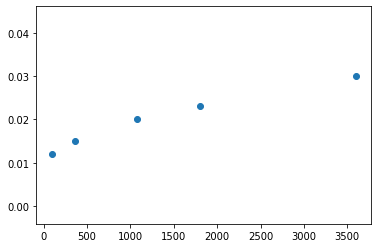

In [129]:
#=================== Aplico esta función al plazo que tengo para la curva =======================
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]
intervalo_curva=intervalo(plazo_curva)

print(plazo_curva,len(plazo_curva))

# ====================== Gráfico la curva con los valores iniciales ======================
tasas_curva=[0.012,0.015,0.02,0.023,0.03]
plt.scatter(plazo_curva[1:],tasas_curva)

In [10]:
# ========================== Veo como está el intervalo ===================================
intervalo_curva

array([[   0,   90],
       [  90,  360],
       [ 360, 1080],
       [1080, 1800],
       [1800, 3600]])

### Funciones para la creación de los plazos de la curva a la medidad del instrumento y el DF

In [11]:
def plazo_curva_fw(plazo_instrumento, plazos_curva):
    #plazo_instrumento: plazo de vencicimiento del instrumento
    #plazo_curva: plazos de la curva forward
    
    # Con esta fórmula construyo la base de plazos, teniendo en cuenta la duración del instrumento
    # lo que intento hacer es encontrar el mínimo entre los plazos
    # de esta manera si el venciemiento es menor al plazo tomo como referencia el plazo
    nuevos_plazos=[]
    for plazo in plazos_curva:
        nuevos_plazos=np.append(nuevos_plazos,min(plazo,plazo_instrumento))
    
    return intervalo(nuevos_plazos)
    
def DF(tasas_forwards, plazos):
    #tasa_forwards: tasas de la curva
    #plazos: plazos de a los que quiero valorar cada instrumento
    #tipo: tipo de crédito swap o libor
    
    #=========== Esto solo sirve para libor ===============================
    
    #con esta fórmula encuentro el factor de descuente para cada fecha
    #el factor se inicia en cero porque es el tiempo t=1
    # la fórmila sirve tanto para sacar los factores de descuento de libor y swaps
    # deja como variables las tasas forwards
    factor_d=[]
   
    for i in range(1,len(tasas_forwards)):
        periodo=(plazos[i][1]-plazos[i][0])/dia_año
        if periodo==0:
            FD_1=1
            factor_d=np.append(factor_d,FD_1)
        else:
            FD_1=np.exp(-tasas_forwards[i]*(periodo))#FD_1=mt.exp(-tasas_forwards[i])
            factor_d=np.append(factor_d,FD_1)
                
    return factor_d

In [12]:
#verificar que hace formula
plazo_curva_fw(1500,plazo_curva)

array([[   0.,   90.],
       [  90.,  360.],
       [ 360., 1080.],
       [1080., 1500.],
       [1500., 1500.]])

In [13]:
años=7
2*(años*360/360)

14.0

In [14]:
#verificar que hace la formula de los factores
DF(tasas_curva,plazo_curva_fw(2*360,plazo_curva))

array([0.98881304, 0.98019867, 1.        , 1.        ])

# Fórmulas de valoración

In [15]:
def libor(tasa,tipo_libor,tasas_curva):
    # Con esta formula puedo saber cuanto se debe pagar al final del periodo con un crédito Libor
    #tasa: tasa libor para el periodo t
    # tipo libor: tipo de contrato
    # plazo curva: plazos de las curva forward
    global plazo_curva
    tipo=tipo_libor
    plazo_dias=plazos[tipo]
    vf_libor=100*(1+tasa*(plazo_dias/360))
    vp_libor=vf_libor*DF(tasas_curva,plazo_curva_fw(plazo_dias,plazo_curva)).prod()
    return vp_libor

def fd_swaps(plazo_vencimiento,tasas_curva):
    # plazo vencimiento: plazo en el que vence el contrato 
    # con esta fórmula puedo sacar el valor presente de un crédito libor o un crédito diferente
    # para cada factor de descuento
    global plazo_curva
    factor=0
    factor_final=0
    for i in range(int(plazo_vencimiento/360)*2):
        fd=DF(tasas_curva,plazo_curva_fw((i+1)*6*30,plazo_curva)).prod()
        factor+=fd
        factor_final=fd
    return factor,factor_final

def swap(cupon,tipo_swap,tasas_curva):
    # cupon: valor en % del cupon. Dejarlo expresado en decimales
    # Tipo de swap es el nombre del swap segun bloomberg
    tipo=tipo_swap
    plazo_dias=plazos[tipo]
    fd=fd_swaps(plazo_dias,tasas_curva)
    vp_swap=100*(1/2)*cupon*fd[0]+100*fd[1]
    return vp_swap

In [16]:
tasas_curva=[0.015,0.015,0.02,0.023,0.03]
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

fd_swaps(2*360,tasas_curva)

(3.9332774919831084, 0.9692332344763441)

In [99]:
instrumento=4
swap(datos.iloc[500][instrumento],nombre[instrumento],tasas_curva)

99.72518257861367

In [17]:
instrumento=0
libor(datos.iloc[500][instrumento],nombre[instrumento],tasas_curva)
#libor(datos.iloc[0][datos.columns[columna]],datos.columns[columna],tasas_curva)[0]

100.47490750000001

In [18]:
np.array(datos.iloc[0])

array([0.0172152, 0.0188769, 0.0217313, 0.021946 , 0.022975 , 0.023949 ,
       0.024604 , 0.025405 ])

# Metodo de calibración

### Función de evaluación 

In [19]:
def error_cuadrado(tasas_curva,datos):
    # función a optimizar
    # tasa_curva: son las tasas que se quieren encontrar
    # datos es el dato para una fecha específica
    global plazo_curva
    global tipo
    error_cuadrado=0
    for instrumento in range(len(datos)):
        if tipo[instrumento]=="libor":
            error=100-libor(datos[instrumento],nombre[instrumento],tasas_curva)
            error_cuadrado+=error**2
        else:
            error=100-swap(datos[instrumento],nombre[instrumento],tasas_curva)
            error_cuadrado=+error**2
    return error_cuadrado

### Optimizador

In [26]:
tasas_iniciales=[0.015,0.015,0.02,0.023,0.03]
plazo_curva=[0,3*dias_mes,dia_año,3*dia_año,5*dia_año,10*dia_año]

def optimizador(datos,error_cuadrado):
    global plazo_curva
    global tasas_iniciales
    # Encuentre el mínimo error posible, bajo las tasas de la cuerva forward
    result=spo.minimize(error_cuadrado,tasas_iniciales,args=(datos,),method="SLSQP",options={"disp":True})
    return result

In [110]:
#================ Prueba del optimizador =====================================
result=optimizador(datos.iloc[300],error_cuadrado)
result.x

C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.385329558254575e-07
            Iterations: 13
            Function evaluations: 134
            Gradient evaluations: 13


array([ 0.015     , -0.04337284, -0.11381943, -0.82609498,  0.55097556])

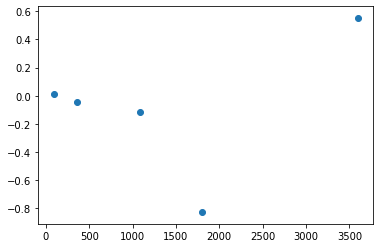

In [111]:
plt.scatter(plazo_curva[1:],result.x)

In [131]:
tasa_fwrd=[]
for fecha in datos.index:
    tasa_fwrd=np.append(optimizador(datos.loc[fecha],error_cuadrado).x,tasa_fwrd)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.775776424803087e-07
            Iterations: 4
            Function evaluations: 38
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0404671030550029e-07
            Iterations: 3
            Function evaluations: 32
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.654510554301439e-09
            Iterations: 5
            Function evaluations: 46
            Gradient evaluations: 5


C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.380389665339295e-07
            Iterations: 11
            Function evaluations: 97
            Gradient evaluations: 11


C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.159869469745964e-09
            Iterations: 11
            Function evaluations: 98
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0754056205420854e-10
            Iterations: 11
            Function evaluations: 104
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.290264869277161e-07
            Iterations: 9
            Function evaluations: 87
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 9.293978710491819e-08
            Iterations: 12
            Function evaluations: 114
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.3870782606998096e-07
            Iterations: 11
  

C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.8340883259626335e-12
            Iterations: 13
            Function evaluations: 122
            Gradient evaluations: 13


C:\Users\mariaalejandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.31053515126066e-09
            Iterations: 12
            Function evaluations: 112
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.0939707338052798e-08
            Iterations: 10
            Function evaluations: 93
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.685719130635524e-08
            Iterations: 12
            Function evaluations: 124
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.653953634199007e-09
            Iterations: 14
            Function evaluations: 132
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6933758988221977e-11
            Iterations: 12


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.9621217839970455e-09
            Iterations: 10
            Function evaluations: 110
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1152345270469957e-07
            Iterations: 11
            Function evaluations: 117
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2922630203911647e-10
            Iterations: 13
            Function evaluations: 132
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.4899661687068896e-07
            Iterations: 10
            Function evaluations: 97
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.989040378629843e-10
            Iterations: 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.529940903586142e-11
            Iterations: 11
            Function evaluations: 101
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0406989518076217e-09
            Iterations: 15
            Function evaluations: 155
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.124343866151055e-08
            Iterations: 10
            Function evaluations: 95
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.861661738680434e-09
            Iterations: 12
            Function evaluations: 109
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.073830573392215e-11
            Iterations: 13


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.5545470232554582e-09
            Iterations: 18
            Function evaluations: 186
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.36033333710846e-08
            Iterations: 9
            Function evaluations: 96
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.286441123362031e-12
            Iterations: 16
            Function evaluations: 155
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8.056615531508003e-09
            Iterations: 11
            Function evaluations: 103
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.5178951635953764e-07
            Iterations: 11
  

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.290942346314259e-10
            Iterations: 11
            Function evaluations: 106
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4044294941325336e-09
            Iterations: 11
            Function evaluations: 101
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.662580806972706e-09
            Iterations: 14
            Function evaluations: 142
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.3670955634232994e-07
            Iterations: 14
            Function evaluations: 135
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0802528371140592e-11
            Iterations: 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2971846846903409e-11
            Iterations: 19
            Function evaluations: 184
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.255813091398994e-10
            Iterations: 15
            Function evaluations: 138
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.59558148223155e-10
            Iterations: 11
            Function evaluations: 99
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.1817314036751967e-10
            Iterations: 11
            Function evaluations: 99
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.887302482706132e-11
            Iterations: 13
 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.517384084374675e-08
            Iterations: 14
            Function evaluations: 135
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.98600290969583e-08
            Iterations: 10
            Function evaluations: 100
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.883242433782064e-10
            Iterations: 13
            Function evaluations: 122
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.41701739324469e-08
            Iterations: 14
            Function evaluations: 142
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.608144570799837e-09
            Iterations: 8
   

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.186058640112948e-08
            Iterations: 9
            Function evaluations: 84
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5679899578871342e-10
            Iterations: 12
            Function evaluations: 112
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.601741936675395e-09
            Iterations: 12
            Function evaluations: 115
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.721374608102573e-10
            Iterations: 12
            Function evaluations: 107
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2468283797089547e-10
            Iterations: 10
 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.329057079125692e-08
            Iterations: 8
            Function evaluations: 75
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.196876120948065e-07
            Iterations: 5
            Function evaluations: 45
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2142673826861999e-09
            Iterations: 6
            Function evaluations: 53
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.081274072148033e-10
            Iterations: 7
            Function evaluations: 64
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.051905767089791e-09
            Iterations: 6
            

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.3882472932761508e-07
            Iterations: 8
            Function evaluations: 67
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.8768773152908664e-09
            Iterations: 7
            Function evaluations: 61
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.69737877646599e-08
            Iterations: 6
            Function evaluations: 53
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.242342680922686e-08
            Iterations: 5
            Function evaluations: 46
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0476063468651755e-07
            Iterations: 6
           

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4995168804292662e-10
            Iterations: 6
            Function evaluations: 52
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.711669941261012e-07
            Iterations: 7
            Function evaluations: 58
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.9066279377365147e-07
            Iterations: 7
            Function evaluations: 58
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.965700696189762e-09
            Iterations: 7
            Function evaluations: 58
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.867353819051042e-08
            Iterations: 8
           

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.79180217190544e-09
            Iterations: 6
            Function evaluations: 51
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.447999235394722e-09
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.393720185396588e-08
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2577895518292692e-08
            Iterations: 7
            Function evaluations: 57
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.137035129583207e-09
            Iterations: 8
            F

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.243487350751788e-07
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.577535658673028e-07
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.153908630115735e-07
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.639630500982864e-07
            Iterations: 8
            Function evaluations: 65
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1770705125328795e-09
            Iterations: 6
            

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.651612274177943e-09
            Iterations: 5
            Function evaluations: 46
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.0508702418704727e-09
            Iterations: 5
            Function evaluations: 44
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.356013716403948e-08
            Iterations: 4
            Function evaluations: 37
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.878706947431294e-09
            Iterations: 4
            Function evaluations: 37
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.406586778802843e-09
            Iterations: 5
            

In [133]:
tasa_fwrd[:5]

array([ 0.015     ,  0.34031778,  0.27121307, -0.22075155, -0.04708968])

In [141]:
x=np.array([np.array(tasa_fwrd[i:i+5]) for i in range(0,len(tasa_fwrd)-1,5)])

In [151]:
tasas_forward_finales=pd.DataFrame(x,index=datos.index)
tasas_forward_finales.to_csv("tasas_finales.csv")